In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [3]:
newsdata = fetch_20newsgroups(subset='train')

In [4]:
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [5]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


In [7]:
newsdata.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [10]:
newsdata.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [13]:
newsdata.target_names[7]

'rec.autos'

In [16]:
data = pd.DataFrame(newsdata.data, columns=['email'])
data['target'] = pd.Series(newsdata.target)
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


In [20]:
data.isnull().values.any()

False

In [22]:
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수: {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수: 20


<AxesSubplot:>

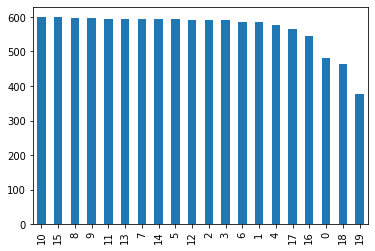

In [23]:
data['target'].value_counts().plot(kind='bar')

In [25]:
print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [26]:
newsdata_test = fetch_20newsgroups(subset='test',shuffle=True)
train_email = data['email']
train_label = data['target']
test_email = newsdata_test.data
test_label = newsdata_test.target

In [27]:
max_words = 10000
num_classes = 20

In [28]:
def prepare_data(train_data, test_data, mode):
    t = Tokenizer(num_words = max_words)
    t.fit_on_texts(train_data)
    X_train = t.texts_to_matrix(train_data, mode=mode)
    X_test = t.texts_to_matrix(test_data, mode=mode)
    return X_train, X_test, t.index_word

In [29]:
X_train, X_test, index_to_word = prepare_data(train_email,test_email,'binary')
y_train = to_categorical(train_label, num_classes)
y_test = to_categorical(test_label, num_classes)

In [30]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [33]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [39]:
def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256,input_shape=(max_words,),activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

In [40]:
modes = ['binary','count','tfidf','freq']
for mode in modes:
    X_train, X_test, _ = prepare_data(train_email, test_email, mode)
    score = fit_and_evaluate(X_train, y_train, X_test, y_test)
    print(mode+'모드의 테스트 정확도:',score)

Epoch 1/5
80/80 [==============================] - 1s 12ms/step - loss: 2.3251 - accuracy: 0.3313 - val_loss: 0.9775 - val_accuracy: 0.8127
Epoch 2/5
80/80 [==============================] - 1s 10ms/step - loss: 0.8800 - accuracy: 0.7555 - val_loss: 0.4715 - val_accuracy: 0.8860
Epoch 3/5
80/80 [==============================] - 1s 11ms/step - loss: 0.4200 - accuracy: 0.8914 - val_loss: 0.3354 - val_accuracy: 0.9019
Epoch 4/5
80/80 [==============================] - 1s 10ms/step - loss: 0.2550 - accuracy: 0.9362 - val_loss: 0.3085 - val_accuracy: 0.9170
Epoch 5/5
80/80 [==============================] - 1s 10ms/step - loss: 0.1750 - accuracy: 0.9567 - val_loss: 0.2994 - val_accuracy: 0.9134
binary모드의 테스트 정확도: 0.8256770968437195
Epoch 1/5
80/80 [==============================] - 1s 12ms/step - loss: 2.7336 - accuracy: 0.2484 - val_loss: 1.5960 - val_accuracy: 0.7314
Epoch 2/5
80/80 [==============================] - 1s 10ms/step - loss: 1.4503 - accuracy: 0.6320 - val_loss: 0.7122 - val